# Introduction
this pipe line use idea of compairing vector similarity to detect most similar faces

here is overview


```mermaid.js
face DB --> CLIP model embedding --> FAISS vector DB \
                                                      ----------------> vector similarity list --> thredsholding --> majority
camera --> face detection --> extract --> transform --> CLIP model /
```



# Initiallze colab

In [4]:
!pip install -q transformers pillow faiss-cpu torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.2 MB/s eta 0:00:00


In [10]:
!git clone https://github.com/Besutodesuka/Retriver_for_verification.git

Cloning into 'Retriver_for_verification'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 15 (delta 2), reused 5 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 6.34 KiB | 6.34 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [2]:
import os
import numpy as np
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
import faiss

# Load dataset

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenCV li

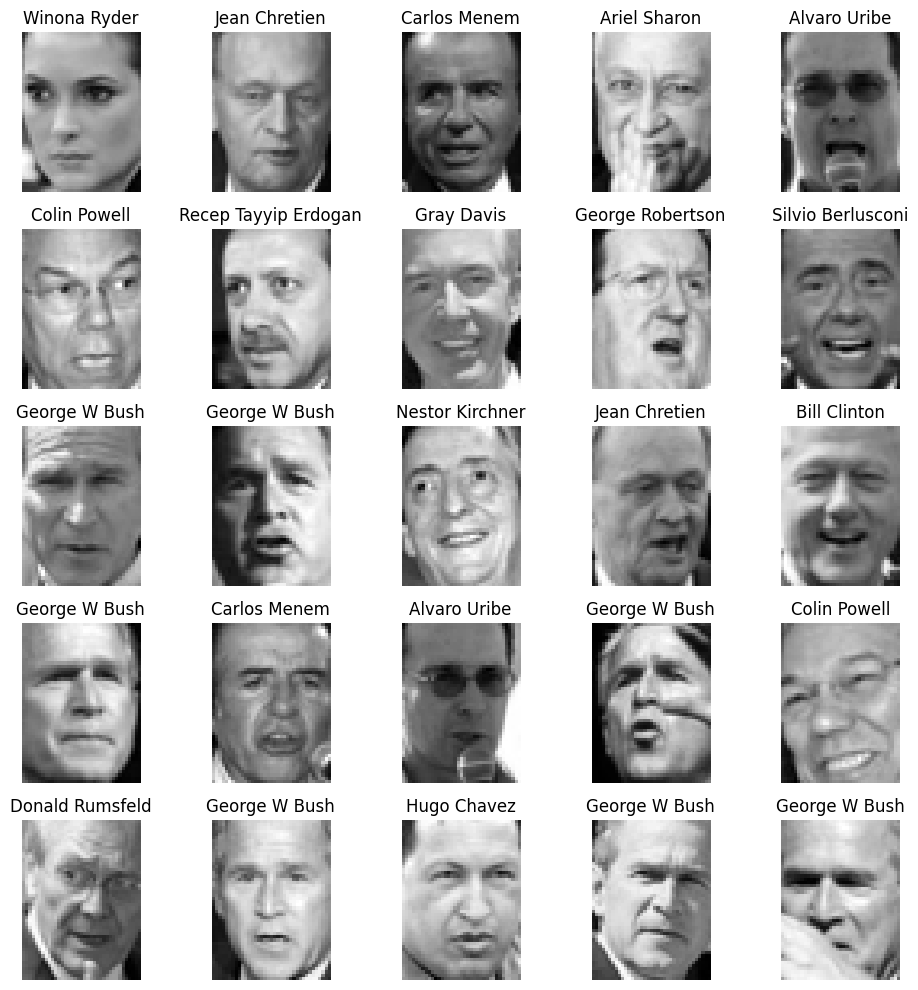

In [3]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt

# Download the LFW dataset; here, we filter to persons with at least 20 images each for consistency.
lfw_dataset = fetch_lfw_people(min_faces_per_person=20, resize=0.4)

# Print dataset description and details
print(lfw_dataset.DESCR)
print(f"Number of images: {lfw_dataset.images.shape[0]}")
print(f"Image dimensions: {lfw_dataset.images.shape[1]} x {lfw_dataset.images.shape[2]}")
print(f"Number of classes: {len(lfw_dataset.target_names)}")

# Visualize some sample images from the dataset
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(lfw_dataset.images[i], cmap='gray')
    ax.set_title(lfw_dataset.target_names[lfw_dataset.target[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
lfw_dataset.images.shape

(3023, 50, 37)

In [5]:
lfw_dataset.target.shape

(3023,)

In [6]:
# prompt: import train test_split

from sklearn.model_selection import train_test_split

# Assuming you want to split the dataset into training and testing sets for your face recognition model.
# You can adapt this based on how you're planning to use the dataset.

image_raw_db, test_image, db_class_id, test_ans = train_test_split(
    lfw_dataset.images,  # Your image data
    lfw_dataset.target,  # Your corresponding labels (person IDs)
    test_size=0.05,  # Adjust the test size as needed
    random_state=42,  # Set a random state for reproducibility
    stratify=lfw_dataset.target
)

print(f"Training set size: {image_raw_db.shape[0]}")
print(f"Testing set size: {test_image.shape[0]}")

# You can now use X_train, X_test, y_train, y_test to train your model and evaluate it.
# For example, you could extract embeddings for the training images, build a FAISS index,
# and then use the test images to evaluate the accuracy of face verification.


Training set size: 2871
Testing set size: 152


# Construct the detector

In [39]:
from tqdm import tqdm
def extract_embedding(image_path, model, processor):
    """
    Load an image, process it with the CLIP processor,
    and return the normalized image embedding.
    """
    if type(image_path) is str:
      image = Image.open(image_path).convert("RGB")
    elif type(image_path) is np.ndarray:
      image = Image.fromarray(image_path)
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get image embeddings
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)

    # Convert to numpy and normalize
    embedding = outputs.cpu().numpy()[0]
    norm = np.linalg.norm(embedding)
    if norm != 0:
        embedding = embedding / norm
    return embedding

def build_face_database(image_folder, model, processor):
    """
    Build a database of embeddings from all images in the folder.
    Returns:
        - embeddings: numpy array of shape (N, D)
        - filenames: list of image filenames corresponding to the embeddings.
    """
    embeddings = []
    filenames = []
    if type(image_folder) is str:
      for filename in tqdm(os.listdir(image_folder)):
          image_path = os.path.join(image_folder, filename)
          try:
              emb = extract_embedding(image_path, model, processor)
              embeddings.append(emb)
              filenames.append(filename)
              # print(f"Processed {filename}")
          except Exception as e:
              print(f"Error processing {filename}: {e}")
    elif type(image_folder) is np.ndarray:
      # this case it might are np.array
      for id, image in tqdm(enumerate(image_folder)):
        try:
            emb = extract_embedding(image, model, processor)
            embeddings.append(emb)
            filenames.append(id)
            # print(f"Processed {id}")
        except Exception as e:
            print(f"Error processing {id}: {e}")


    embeddings = np.vstack(embeddings).astype('float32')
    return embeddings, filenames

def create_faiss_index(embeddings):
    """
    Create a FAISS index for normalized embeddings using inner product.
    With normalized vectors, inner product is equivalent to cosine similarity.
    """
    d = embeddings.shape[1]
    index = faiss.IndexFlatIP(d)  # inner product index
    index.add(embeddings)
    return index

def verify_face(query_image_path, index, index_class_id, model, processor, top_k=3, similarity_threshold=0.6):
    """
    Extract the embedding for the query image, search for the top K nearest neighbors,
    and compute the average similarity score. If the average similarity exceeds the threshold,
    return verification True.
    """
    query_embedding = extract_embedding(query_image_path, model, processor).reshape(1, -1).astype('float32')
    # FAISS expects a batch of query vectors
    similarities, indices = index.search(query_embedding, top_k)
    retrieved_class = [index_class_id[i] for i in indices]

    # # similarities are inner product scores (cosine similarity since embeddings are normalized)
    # avg_similarity = np.mean(similarities)

    for score,pred in zip(similarities, retrieved_class):
      print(f"class: {pred} score: {score}")

    # # Print details for inspection.
    # print("Top similar images:")
    # for i, idx in enumerate(indices[0]):
    #     print(f"{i+1}. {filenames[idx]} - similarity: {similarities[0][i]:.3f}")

    # print(f"Average similarity: {avg_similarity:.3f}")
    # verified = avg_similarity >= similarity_threshold
    # return verified, avg_similarity

#unit test

In [26]:
# Initialize the Hugging Face CLIP model and processor.
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

### picture is numpy array

In [12]:
# Build the face database: embeddings and corresponding image.
embeddings, filenames = build_face_database(image_raw_db, model, processor)

2871it [00:28, 101.73it/s]


In [15]:
# Create the FAISS index from the embeddings.
index = create_faiss_index(embeddings)

In [35]:
np.expand_dims(test_image[0], 0).shape

(1, 50, 37)

In [20]:
test_ans[0]

np.int64(33)

In [41]:
query_image = test_image[0] # np.expand_dims(test_image[0], 0)

verify_face(query_image, index, db_class_id, model, processor, top_k=100, similarity_threshold=0.6)
# verified, avg_similarity =
# if verified:
#     print("Face verified!")
# else:
#     print("Face not verified!")

class: [10 35 14  5 61 14 14 53 21 14 41 22 14 25  5 54  2 20 14 52 57 58 10 27
  9 14 10 27 52 14 14 14 58 47 27  1 14 10 10 10  2 58 33  5  6 10 30 35
 14 12 21 58 14 49 34 54 14 29 21 19 39  5 40 14 39 10 14 53 49 10 15 38
 15 10 10  3  5 15 10 11 38 60 42 55  0 58 49 40 40 14 12 42 29 50 15 10
 21 29 14 14] score: [0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996
 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996
 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996
 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996
 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996
 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996
 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996
 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996
 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996 0.9999996
 0.9999996 0.9999996 0.9999996 0.9999996 

### when picture is in images

In [27]:

# Folder containing known face images (each image should have one face ideally)
known_faces_folder = "known_faces"

# Build the face database: embeddings and corresponding filenames.
embeddings, filenames = build_face_database(image_raw_db, model, processor)

if embeddings.shape[0] == 0:
    print("No valid embeddings found in the database.")
    exit(1)

# Create the FAISS index from the embeddings.
index = create_faiss_index(embeddings)

# Query image to verify
query_image_path = "query_face.jpg"

verified, avg_similarity = verify_face(query_image_path, index, filenames, model, processor,
                                        top_k=3, similarity_threshold=0.6)

if verified:
    print("Face verified!")
else:
    print("Face not verified!")

670it [00:06, 101.96it/s]


KeyboardInterrupt: 

In [28]:
type(np.array([]))

numpy.ndarray